In [1]:
from lxml import html
import requests
from bs4 import BeautifulSoup
import urllib
import urllib2
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import interp1d
import emcee
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
r = urllib.urlopen('http://www.buda.org/leagues/past-leagues')
soup = BeautifulSoup(r, 'html.parser')

In [3]:
iframe = soup.find_all('iframe')[0]
response = urllib2.urlopen(iframe.attrs['src'])
iframe_soup = BeautifulSoup(response)

In [4]:
leaguelinks = [i.a['href'] for i in iframe_soup.find_all("td", class_="infobody")]

In [7]:
i.get_text()

u'Summer Hat League- 1999'

In [85]:
# define the dictionary that will contain all player ratings
all_players = {}

# loop over all leagues in the BUDA database
for link in leaguelinks:

    # extract the league id for this league
    leagueid = link[link.index('league=') + 7:]

    # scrape the scores for this league
    leaguescoreurl = 'http://www.buda.org/hatleagues/scores.php?section=showLeagueSchedule&league=' + leagueid + '&byDivision=1&showGames=1'
    response = urllib2.urlopen(leaguescoreurl)
    leaguescore_soup = BeautifulSoup(response)

    # assemble the data of team ratings for this league
    data = []
    data_opponent = []
    try:
        table = leaguescore_soup.find_all('table', attrs={'class':'info'})[1]
    except IndexError:
        print("Unable to find a database of scores for league {}".format(leagueid))
        continue
    rows = table.find_all('tr')
    for row in rows:
        cols = row.find_all('th')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
        tdcols = row.find_all('td')
        tdcols = [ele.text.strip() for ele in tdcols]
        data_opponent.append([ele for ele in tdcols if ele]) # Get rid of empty values

    # convert to dataframe and drop irrelevant columns
    dfdata = pd.DataFrame(data)
#     print(leagueid, dfdata.columns)
    dfdata.columns = dfdata.ix[0, :]#['Team', 'Record', 'Plus/Minus', 'Tourney Qualifying games']
#     print(leagueid, dfdata.columns)
    dfdata = dfdata.drop(0).reset_index()
    
    # fill na's with -99 to facilitate division dividers
    dfdata = dfdata.fillna(-99)
    
    # get the list of divisions in this league
    divnames = dfdata.ix[dfdata['Record'] == -99, 'Team'].values
    if len(divnames) == 0:
        print("No divisions found, skipping league {}".format(leagueid))
        continue

    # define base ratings by division (arbitrarily assigned based on my experience)
    divratings = {'4/3 Div 1': 1800, '4/3 Div 2': 1400, '4/3 Div 3': 1000, '4/3 Div 4': 900, 
                '5/2 Div 1': 1700, '5/2 Div 2': 1300, '5/2 Div 3': 900, '5/2 Div 4': 800,
                'Open Div 1': 1400, 'Open Div 2': 1200}
    dfdata['div'] = np.zeros(len(dfdata))
    for i in range(len(divnames)-1):
        try:
            divstart = np.where(dfdata['Team'] == divnames[i])[0][0]
        except IndexError:
            print("{} not found, skipping league {}".format(divnames[i], leagueid))
            continue
        try:
            divend = np.where(dfdata['Team'] == divnames[i + 1])[0][0]
        except IndexError:
            print("{} not found, skipping league {}".format(divnames[i + 1], leagueid))
            continue
        try:
            dfdata.ix[divstart + 1: divend, 'div'] = divratings[divnames[i]]
        except KeyError:
            print("No base rating for {}, skipping league {}".format(divnames[i], leagueid))
            continue
    try:
        dfdata.ix[divend + 1:, 'div'] = divratings[divnames[-1]]
    except KeyError:
        print("No base rating for {}, skipping league {}".format(divnames[-1], leagueid))
        continue        

    # remove the division dividers from the dataframe
    for i in range(len(divnames)):
        dfdata = dfdata.drop(dfdata.index[dfdata['Team'] == divnames[i]])

    # generate the average goal differential column
    dfdata['wins'] = dfdata['Record'].apply(lambda x: int(x.split('-')[0]))
    dfdata['losses'] = dfdata['Record'].apply(lambda x: int(x.split('-')[1]))
    dfdata['games'] = dfdata['wins'] + dfdata['losses']
    dfdata['avgplusminus'] = dfdata['Plus/Minus'].astype('float') / dfdata['games']

    # assert that an average goal differential per game of +5 gives +300 rating points.
    dfdata['rating'] = dfdata['div'] + 60. * dfdata['avgplusminus']

    # build the dictionary of game scores
    dfdata_opponents = pd.DataFrame(data_opponent)
    dfdata_opponents['teamscore'] = dfdata.ix[:, 1].apply(lambda x: int(x.split('-')[0]))
    dfdata_opponents['opponentscore'] = dfdata.ix[:, 1].apply(lambda x: int(x.split('-')[1]))

    opponentcounter = 0
    game_scores = {}
    for idf in range(len(dfdata)):
        teamname = dfdata.ix[idf, 'Team']
        ngames = dfdata.ix[idf, 'games']
        for igame in range(ngames):
            opponentname = dfdata_opponents.ix[opponentcounter, 0]
            teamscore = dfdata_opponents.ix[opponentcounter, 'teamscore']
            opponentscore = dfdata_opponents.ix[opponentcounter, 'opponentscore']
            adversary_key = (teamname, opponentname)
            game_scores[adversary_key] = [teamscore, opponentscore]
    
    # scrape the list of teams for this league
    teamsurl = 'http://www.buda.org/hatleagues/rosters.php?section=showTeams&league=' + leagueid
    response = urllib2.urlopen(teamsurl)
    teams_soup = BeautifulSoup(response)

    # generate list of team ids and names for this league
    tdlist = teams_soup.find_all('td', class_='infobody')
    teamids = []
    teamnames = []
    for td in tdlist:
        try:
            url = td.a['href']
            idindex = url.index('team=')
            whichindex = url.index('which=')
            teamids.append(url[idindex+5:whichindex-1])
            teamnames.append(td.a.get_text())
        except:
            continue

    # find all players associated with each team
    # link the team rating to each player on that team
    for teamid, teamname in zip(teamids, teamnames):
        try:
            teamrating = dfdata.ix[dfdata['Team'] == teamname.strip(' '), 'rating'].values[0]
        except IndexError:
            print("Couldn't match {} to scores database, skipping this team.".format(teamname))
            continue

        teamurl = 'http://www.buda.org/hatleagues/rosters.php?section=showTeamRoster&team=' + teamid
        response = urllib2.urlopen(teamurl)
        roster_soup = BeautifulSoup(response)

        players = [td.get_text() for td in roster_soup.find_all("td", class_="infobody")]
        for player in players:
            if player in all_players:
                all_players[player].append(teamrating)
            else:
                all_players[player] = [teamrating]
    print("Finished successfully with league {}".format(leagueid))

Unable to find a database of scores for league 40491
Unable to find a database of scores for league 40278
Unable to find a database of scores for league 40273
Unable to find a database of scores for league 40268
Unable to find a database of scores for league 40264
Unable to find a database of scores for league 40258
Unable to find a database of scores for league 40253
Unable to find a database of scores for league 40249
Unable to find a database of scores for league 40245
No base rating for Northborough Open, skipping league 39633
No base rating for Danvers Weeknight, skipping league 39633
No base rating for Danvers Weekend, skipping league 39633
Unable to find a database of scores for league 39960
Unable to find a database of scores for league 39939
Unable to find a database of scores for league 39904
Unable to find a database of scores for league 39678
Unable to find a database of scores for league 39673
Finished successfully with leage 39641
No base rating for Northborough Open, ski

In [87]:
all_players.pop('')

[1635.0,
 1500.0,
 1455.0,
 1940.0,
 1908.0,
 2020.0,
 1944.0,
 2115.0,
 1740.0,
 1688.5714285714287,
 1662.8571428571429,
 1785.0,
 1750.0,
 1025.0,
 1205.0,
 800.0,
 1408.5714285714287,
 1254.2857142857142,
 1845.7142857142858,
 1040.0,
 1592.0,
 1415.0,
 1220.0,
 1751.4285714285713,
 1208.0,
 1280.0,
 1412.0,
 1340.0,
 1230.0,
 1460.0,
 1357.1428571428571,
 1580.0,
 1648.5714285714287,
 1520.0,
 1500.0,
 1452.5,
 922.85714285714289,
 1168.0,
 1390.0,
 620.0,
 616.0,
 890.0,
 905.71428571428578,
 957.14285714285711,
 1248.5714285714287,
 1135.0,
 725.71428571428578,
 1408.0,
 900.0,
 1317.1428571428571,
 1328.0,
 1004.0,
 1440.0,
 1797.5,
 1380.0,
 680.0,
 1920.0,
 1424.0,
 1632.5,
 390.0,
 1813.3333333333333,
 1868.5714285714287,
 2005.7142857142858,
 2061.1764705882351,
 1812.0,
 1860.0,
 1687.5,
 1626.0,
 2070.0,
 1202.0,
 1516.25,
 1657.1428571428571,
 1463.3333333333333,
 1526.3157894736842,
 1262.0,
 1373.3333333333333,
 1271.4285714285716,
 1386.1538461538462,
 1164.2857142857

In [90]:
import pickle

pickle.dump(all_players, open( "all_players.p", "wb" ) )

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

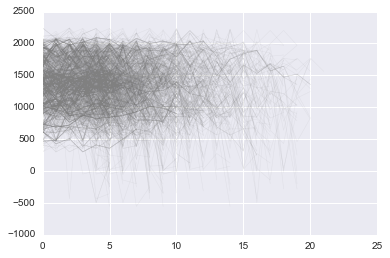

In [93]:
%matplotlib inline
for player in all_players.keys():
    if len(all_players[player]) > 5:
        plt.plot(all_players[player], color='gray', lw=0.5, alpha=0.1)

In [124]:
pmean = []
players_means = {}
for player in all_players.keys():
    pratings = np.array(all_players[player])
    toolow = np.where(pratings < 0)
    if toolow[0].size > 0:
        pratings[toolow[0]] = 0
    pmean.append(pratings.mean())
    if pratings.mean() < 0:
        print(pratings)
    players_means[player] = pratings.mean()

In [122]:
pdf = pd.DataFrame(pmean)

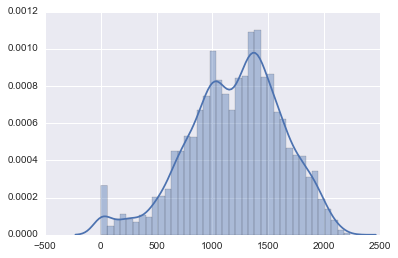

In [123]:
sns.distplot(pdf.dropna())

In [130]:
# extract the league id for this league
springhat2016id = '40258'
leagueid = springhat2016id

# scrape the list of teams for this league
teamsurl = 'http://www.buda.org/hatleagues/rosters.php?section=showTeams&league=' + leagueid
response = urllib2.urlopen(teamsurl)
teams_soup = BeautifulSoup(response)

# generate list of team ids and names for this league
tdlist = teams_soup.find_all('td', class_='infobody')
teamids = []
teamnames = []
for td in tdlist:
    try:
        url = td.a['href']
        idindex = url.index('team=')
        whichindex = url.index('which=')
        teamids.append(url[idindex+5:whichindex-1])
        teamnames.append(td.a.get_text())
    except:
        continue

# find all players associated with each team
teamratings = {}
for teamid, teamname in zip(teamids, teamnames):

    teamurl = 'http://www.buda.org/hatleagues/rosters.php?section=showTeamRoster&team=' + teamid
    response = urllib2.urlopen(teamurl)
    roster_soup = BeautifulSoup(response)

    playerratings = []
    players = [td.get_text() for td in roster_soup.find_all("td", class_="infobody")]
    for player in players:
        if player in all_players:
            playerratings.append(players_means[player])
        else:
            # if someone hasn't played club league, they probably aren't very good
            playerratings.append(800)
    # the team rating is the average of the player ratings for that team
    teamratings[teamname] = np.mean(playerratings)
print("Finished successfully with league {}".format(leagueid))

Finished successfully with league 40258


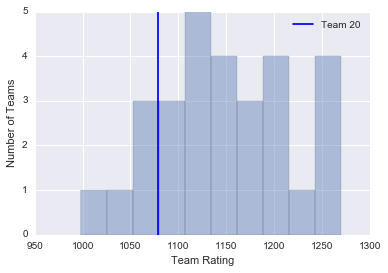

In [156]:
sns.distplot(pd.DataFrame(teamratings.values()).dropna(), kde=False, bins=10)
plt.axvline(teamratings['Team 20 (20)'], label='Team 20')
plt.legend(loc='auto')
plt.ylabel('Number of Teams')
plt.xlabel('Team Rating')
plt.savefig('Team20Rating.png')

In [161]:
teamratings['Team 27 (27)'] = 1000

In [162]:
keylist = []
valuelist = []
for key in teamratings.keys():
    keylist.append(key)
    valuelist.append(teamratings[key])

In [163]:
shl = pd.DataFrame({'team':keylist, 'rating':valuelist})

In [164]:
shl = shl.sort('rating', ascending=False)

In [166]:
shl.team

19         Team 2 (2)
1          Team 3 (3)
21       Team 11 (11)
26       Team 14 (14)
13       Team 23 (23)
23       Team 10 (10)
10       Team 13 (13)
20       Team 19 (19)
2        Team 24 (24)
0        Team 21 (21)
9        Team 22 (22)
17       Team 30 (30)
24         Team 6 (6)
7        Team 12 (12)
22       Team 17 (17)
8          Team 8 (8)
5        Team 18 (18)
3          Team 9 (9)
11       Team 16 (16)
28       Team 15 (15)
29       Team 26 (26)
4        Team 25 (25)
12         Team 7 (7)
18    Mark Hammer (1)
15       Team 20 (20)
27         Team 4 (4)
25       Team 29 (29)
14         Team 5 (5)
16       Team 27 (27)
6        Team 28 (28)
Name: team, dtype: object

In [180]:
5/25.

0.2

In [179]:
2/28.

0.07142857142857142

In [ ]:
def rating_to_point(rating1, rating2):
    
    # tune k so that rating differential of ... corresponds to point ratio of ...
    # 800 ... 0.5
    # 400 ... 0.15
    # 200 ... 0.07
    # 100 ... 0.035
    
    point_ratio1 = 1 / (1 + np.exp(-k * x))
    
    return point_ratio1

In [33]:
# define the dictionary that will contain all player ratings
all_players = {}

# extract the league id for this league
leagueid = '39641'#link[link.index('league=') + 7:]

# scrape the scores for this league
leaguescoreurl = 'http://www.buda.org/hatleagues/scores.php?section=showLeagueSchedule&league=' + leagueid + '&byDivision=1&showGames=1'
response = urllib2.urlopen(leaguescoreurl)
leaguescore_soup = BeautifulSoup(response)

# assemble the data of team ratings for this league
data = []
try:
    table = leaguescore_soup.find_all('table', attrs={'class':'info'})[1]
except IndexError:
    print("Unable to find a database of scores for league {}".format(leagueid))
rows = table.find_all('tr')
for row in rows:
#     cols = row.find_all('th')
#     cols = [ele.text.strip() for ele in cols]
#     if len(cols) == 0:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) # Get rid of empty values

# convert to dataframe and drop irrelevant columns
dfdata = pd.DataFrame(data)

In [35]:
dfdata.dropna().ix[:, 0]

3                 Nutgetters
4             Stormageddon V
5                  FallChart
6         Supermona Reloaded
8                The Animals
9                 BUDA U19 A
10     SnakeCountry Bromance
11        Pickle Bush (LPFK)
12          Somerville Youth
13        Supermona Reloaded
15          Somerville Youth
16      Topless Pillow Fight
17        Supermona Reloaded
18                 FallChart
19              Bear Cavalry
21            Stormageddon V
22     SnakeCountry Bromance
23        Supermona Reloaded
25      Topless Pillow Fight
26                Downstream
27               The Animals
28             Burnt Pudding
29        Supermona Reloaded
31      Topless Pillow Fight
32                 FallChart
33              Haunted HAOS
34       GrassBurner Harvest
35             Burnt Pudding
37        Pickle Bush (LPFK)
38              Bear Cavalry
               ...          
378          Lesley Ultimate
379              Squid Squad
380               Crossroads
382         Bu

Data format should be: dictionary with key as ('Team1, Team2') and value as (score1, score2).  Then, to generate the lnprob, we loop over all keys in the dictionary, building a list of difference delta-ratings.

In [1]:
def point_to_rating(point1, point2):
    base_rating = [-1200, -800,-400,-200,-100,0,100,200,400,800, 1200]
    base_point_ratio = [-1, -0.5, -0.2, -0.07, -0.03, 0.0, 0.03, 0.07, 0.2, 0.5, 1]
    interpfunc = interp1d(base_point_ratio, base_rating)
    point_ratio = (point1 - point2) / (point1 + point2)
    delta_rating = interpfunc(point_ratio)
    return delta_rating
# plt.plot(outputs, indices,'-o')

In [2]:
def lnprob(param):
    
    # set the bounds
    if param.any() < 0:
        return np.inf
    
    if param.any() > 10000:
        return np.inf

    # populate the team ratings according to the current model
    model_ratings = {}
    for iteam, teamname in enumerate(teamnames):
        model_ratings[teamname] = param[iteam]

    # compute the rating delta for both model and data
    model_delta = []
    observed_delta = []
    for gamekey in game_scores.keys():
        key0 = gamekey[0]
        key1 = gamekey[1]
        model_delta.append(model_ratings[key0] - model_ratings[key1])
        observed_delta.append(point_to_rating(game_scores[gamekey][0], game_scores[gamekey][1]))

    # lnprob is defined as mean absolute error between model and true deltas
    probln = -mean_absolute_error(observed_delta, model_delta)
    
    return probln

In [ ]:
# define the dictionary that will contain all player ratings
all_players = {}

# loop over all leagues in the BUDA database
for link in leaguelinks[0]:

    # extract the league id for this league
    leagueid = '39641'#link[link.index('league=') + 7:]

    # scrape the scores for this league
    leaguescoreurl = 'http://www.buda.org/hatleagues/scores.php?section=showLeagueSchedule&league=' + leagueid + '&byDivision=1&showGames=1'
    response = urllib2.urlopen(leaguescoreurl)
    leaguescore_soup = BeautifulSoup(response)

    # assemble the data of team ratings for this league
    data = []
    data_opponent = []
    try:
        table = leaguescore_soup.find_all('table', attrs={'class':'info'})[1]
    except IndexError:
        print("Unable to find a database of scores for league {}".format(leagueid))
        continue
    rows = table.find_all('tr')
    for row in rows:
        cols = row.find_all('th')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
        tdcols = row.find_all('td')
        tdcols = [ele.text.strip() for ele in tdcols]
        data_opponent.append([ele for ele in tdcols if ele]) # Get rid of empty values

    # convert to dataframe and drop irrelevant columns
    dfdata = pd.DataFrame(data)
#     print(leagueid, dfdata.columns)
    dfdata.columns = dfdata.ix[0, :]#['Team', 'Record', 'Plus/Minus', 'Tourney Qualifying games']
    dfdata = dfdata.dropna(how='all')
#     print(leagueid, dfdata.columns)
    dfdata = dfdata.drop(0).reset_index()
    
    dfdata = dfdata.drop(['index', 'Tourney Qualifying games*'], axis=1)
    
    # fill na's with -99 to facilitate division dividers
    dfdata = dfdata.fillna(-99)
    
    # get the list of divisions in this league
    divnames = dfdata.ix[dfdata['Record'] == -99, 'Team'].values
    if len(divnames) == 0:
        print("No divisions found, skipping league {}".format(leagueid))
        continue

    # define base ratings by division (arbitrarily assigned based on my experience)
    divratings = {'4/3 Div 1': 1800, '4/3 Div 2': 1400, '4/3 Div 3': 1000, '4/3 Div 4': 900, 
                '5/2 Div 1': 1700, '5/2 Div 2': 1300, '5/2 Div 3': 900, '5/2 Div 4': 800,
                'Open Div 1': 1400, 'Open Div 2': 1200}
    dfdata['div'] = np.zeros(len(dfdata))
    for i in range(len(divnames)-1):
        try:
            divstart = np.where(dfdata['Team'] == divnames[i])[0][0]
        except IndexError:
            print("{} not found, skipping league {}".format(divnames[i], leagueid))
            continue
        try:
            divend = np.where(dfdata['Team'] == divnames[i + 1])[0][0]
        except IndexError:
            print("{} not found, skipping league {}".format(divnames[i + 1], leagueid))
            continue
        try:
            dfdata.ix[divstart + 1: divend, 'div'] = divratings[divnames[i]]
        except KeyError:
            print("No base rating for {}, skipping league {}".format(divnames[i], leagueid))
            import pdb; pdb.set_trace()

            continue
    try:
        dfdata.ix[divend + 1:, 'div'] = divratings[divnames[-1]]
    except KeyError:
        print("No base rating for {}, skipping league {}".format(divnames[-1], leagueid))
        import pdb; pdb.set_trace()
        continue        

    # remove the division dividers from the dataframe
    for i in range(len(divnames)):
        dfdata = dfdata.drop(dfdata.index[dfdata['Team'] == divnames[i]])

    # generate the average goal differential column
    dfdata['wins'] = dfdata['Record'].apply(lambda x: int(x.split('-')[0]))
    dfdata['losses'] = dfdata['Record'].apply(lambda x: int(x.split('-')[1]))
    dfdata['games'] = dfdata['wins'] + dfdata['losses']
    dfdata['avgplusminus'] = dfdata['Plus/Minus'].astype('float') / dfdata['games']

    # assert that an average goal differential per game of +5 gives +300 rating points.
    dfdata['rating'] = dfdata['div'] + 60. * dfdata['avgplusminus']

    # build the dictionary of game scores
    dfdata_opponents = pd.DataFrame(data_opponent).dropna().reset_index().drop('index', axis=1)
    dfdata_opponents.columns = ['Opponent', 'Record']
    dfdata_opponents['teamscore'] = dfdata_opponents.ix[:, 'Record'].apply(lambda x: int(x.split('-')[0]))
    dfdata_opponents['opponentscore'] = dfdata_opponents.ix[:, 'Record'].apply(lambda x: int(x.split('-')[1]))

    opponentcounter = 0
    game_scores = {}
    for idf in dfdata.index:
        teamname = dfdata.ix[idf, 'Team']
        ngames = dfdata.ix[idf, 'games']
        for igame in range(ngames):
            opponentname = dfdata_opponents.ix[opponentcounter, 'Opponent']
            teamscore = dfdata_opponents.ix[opponentcounter, 'teamscore']
            opponentscore = dfdata_opponents.ix[opponentcounter, 'opponentscore']
            adversary_key = (teamname, opponentname)
            game_scores[adversary_key] = [teamscore, opponentscore]
            
            
    teamnames = dfdata['Team']
    
    ndim = len(dfdata)
    nwalkers = ndim * 2 + 2
    p0 = [np.random.normal(irating, 200, nwalkers) for irating in dfdata['rating']]
    p0 = np.array(p0).transpose()
#     p0 = [np.random.rand(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)
    sampler.run_mcmc(p0, 200)

    plt.plot(sampler.flatchain[:, 0])
    plt.show()
    import pdb; pdb.set_trace()
    
    # scrape the list of teams for this league
    teamsurl = 'http://www.buda.org/hatleagues/rosters.php?section=showTeams&league=' + leagueid
    response = urllib2.urlopen(teamsurl)
    teams_soup = BeautifulSoup(response)

    # generate list of team ids and names for this league
    tdlist = teams_soup.find_all('td', class_='infobody')
    teamids = []
    teamnames = []
    for td in tdlist:
        try:
            url = td.a['href']
            idindex = url.index('team=')
            whichindex = url.index('which=')
            teamids.append(url[idindex+5:whichindex-1])
            teamnames.append(td.a.get_text())
        except:
            continue

    # find all players associated with each team
    # link the team rating to each player on that team
    for teamid, teamname in zip(teamids, teamnames):
        try:
            teamrating = dfdata.ix[dfdata['Team'] == teamname.strip(' '), 'rating'].values[0]
        except IndexError:
            print("Couldn't match {} to scores database, skipping this team.".format(teamname))
            continue

        teamurl = 'http://www.buda.org/hatleagues/rosters.php?section=showTeamRoster&team=' + teamid
        response = urllib2.urlopen(teamurl)
        roster_soup = BeautifulSoup(response)

        players = [td.get_text() for td in roster_soup.find_all("td", class_="infobody")]
        for player in players:
            if player in all_players:
                all_players[player].append(teamrating)
            else:
                all_players[player] = [teamrating]
    print("Finished successfully with league {}".format(leagueid))

> <ipython-input-15-7d9972975925>(122)<module>()
-> sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)
(Pdb) p0.shape
(122, 60)
(Pdb) c
> <ipython-input-15-7d9972975925>(130)<module>()
-> teamsurl = 'http://www.buda.org/hatleagues/rosters.php?section=showTeams&league=' + leagueid
(Pdb) plt.plot(sampler.flatchain[:, 1])
(Pdb) plt.show()
(Pdb) plt.plot(sampler.flatchain[:, 2])
(Pdb) plt.show()


One possible approach would be to say expected point differential is rating differential divided by 100.

In [14]:
dfdata

,Team,Record,Plus/Minus,div,wins,losses,games,avgplusminus,rating
1,SnakeCountry Bromance,4-0-0,21,1800.0,4,0,4,5.250000,2115.000000
2,FallChart,5-1-0,14,1800.0,5,1,6,2.333333,1940.000000
3,Pickle Bush (LPFK),4-1-0,12,1800.0,4,1,5,2.400000,1944.000000
4,Nutgetters,2-1-0,11,1800.0,2,1,3,3.666667,2020.000000
5,GrassBurner Harvest,3-2-0,9,1800.0,3,2,5,1.800000,1908.000000
6,The Animals,2-2-1,-1,1800.0,2,2,4,-0.250000,1785.000000
7,Somerville Youth,1-2-0,-3,1800.0,1,2,3,-1.000000,1740.000000
8,Topless Pillow Fight,2-4-0,-5,1800.0,2,4,6,-0.833333,1750.000000
9,BUDA U19 A,0-2-0,-10,1800.0,0,2,2,-5.000000,1500.000000
10,Stormageddon V,3-4-0,-13,1800.0,3,4,7,-1.857143,1688.571429


Everything is set up except the dictionary of game scores: "game_scores".

In [12]:
np.array(p0).shape

(122, 60)

In [13]:
nwalkers

122